# Conditional Markov Bridge (CMB) for mixed data

### Dataset: 8-gaussians to 2 moons
- continuous: positions in (x,y)-plane
- discrete: 8 position-dependent states 

INFO: created experiment instance Ngaussians_to_moons_FlowMatching_TelegraphProcess_HybridMLP_2024.12.02_19h33_6015


/Users/dario/Dropbox/PROJECTS/ML/CMB/src/cmb/datasets/toys.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return positions * 3 - 1, torch.tensor(labels, dtype=torch.long)
/Users/dario/Dropbox/PROJECTS/ML/CMB/src/cmb/datasets/toys.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return positions, torch.tensor(labels, dtype=torch.long)


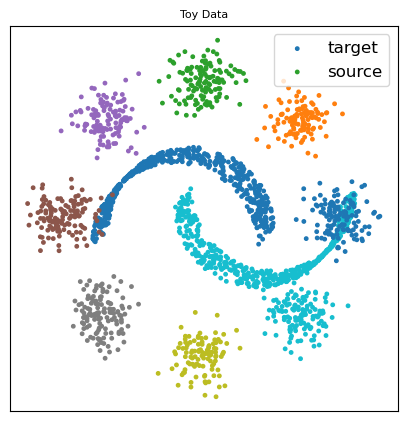

In [1]:
import matplotlib.pyplot as plt
from cmb.configs.utils import Configs
from cmb.datasets.toys import SampleCoupling

config = Configs("configs_cmb.yaml")
toys = SampleCoupling(config=config.data)

_, ax = plt.subplots(1, 1, figsize=(5, 5))

toys.target.display(num_points=1000, s=6, cmap="tab10", alpha=1, ax=ax, label="target")
toys.source.display(num_points=1000, s=6, cmap="tab10", alpha=1, ax=ax, label="source")

plt.legend(fontsize=12)
plt.title("Toy Data", fontsize=8)
plt.show()

In [2]:
from cmb.dynamics.cmb import ConditionalMarkovBridge
from cmb.models.architectures.deep_nets import HybridMLP

dynamics = ConditionalMarkovBridge(config)
mlp = HybridMLP(config)
# model = CMBTrainer(config, dynamics, mlp, toys)
# model.train()

INFO: Conditional Markov Bridge initialized...
      - continuous process:  FlowMatching
      - discrete process:  TelegraphProcess
      - solver method:  EulerLeapingSolver


In [4]:
from cmb.models.trainers import GenerativeDynamicsModule

cmb = GenerativeDynamicsModule(config, toys)
cmb.train()

INFO: number of training parameters: 40666
INFO: number of training parameters: 40666
INFO: start training...
INFO: start training...


INFO: Conditional Markov Bridge initialized...
      - continuous process:  FlowMatching
      - discrete process:  TelegraphProcess
      - solver method:  EulerLeapingSolver
INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 80000, validation size: 20000, testing sizes: 0


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x128 and 1x16)

In [7]:
import torch
import torch.nn as nn
from dataclasses import dataclass


class Pipeline:
    def __init__(
        self,
        config: dataclass,
        trained_model: nn.Module,
        dynamics=None,
        best_epoch_model: bool = True,
    ):
        self.config = config
        self.model = (
            trained_model.best_epoch_model
            if best_epoch_model
            else trained_model.last_epoch_model
        )
        self.dynamics = dynamics
        self.time_steps = torch.linspace(
            0.0, 1.0 - config.pipeline.time_eps, config.pipeline.num_timesteps
        )

    @torch.no_grad()
    def generate_samples(self, **source):
        if self.config.pipeline.method == "EulerSolver":
            solver = EulerSolver(
                config=self.config, model=self.model, dynamics=self.dynamics
            )
            paths = solver.simulate(time_steps=self.time_steps, **source)
            self.paths = paths.detach().cpu()

        elif self.config.pipeline.method == "TauLeapingSolver":
            solver = TauLeapingSolver(
                config=self.config, model=self.model, dynamics=self.dynamics
            )
            jumps = solver.simulate(time_steps=self.time_steps, **source)
            self.jumps = jumps.detach().cpu()

        elif self.config.pipeline.method == "EulerLeapingSolver":
            solver = EulerLeapingSolver(
                config=self.config, model=self.model, dynamics=self.dynamics
            )
            paths, jumps = solver.simulate(time_steps=self.time_steps, **source)
            self.paths = paths.detach().cpu()
            self.jumps = jumps.detach().cpu()

        elif self.config.pipeline.method == "EulerMaruyamaLeapingSolver":
            solver = EulerMaruyamaLeapingSolver(
                config=self.config, model=self.model, dynamics=self.dynamics
            )
            paths, jumps = solver.simulate(time_steps=self.time_steps, **source)
            self.paths = paths.detach().cpu()
            self.jumps = jumps.detach().cpu()

        else:
            raise ValueError("Unknown pipeline method.")


class EulerSolver:
    """Euler ODE solver for continuous states"""

    def __init__(self, config, model, dynamics=None):
        self.device = config.train.device
        self.model = model

    def simulate(
        self,
        time_steps,
        source_continuous,
        context_continuous=None,
        context_discrete=None,
        mask=None,
    ):
        x = source_continuous.to(self.device)
        time_steps = time_steps.to(self.device)
        context_continuous = (
            context_continuous.to(self.device)
            if context_continuous is not None
            else None
        )
        context_discrete = (
            context_discrete.to(self.device) if context_discrete is not None else None
        )
        mask = mask.to(self.device) if mask is not None else None

        delta_t = (time_steps[-1] - time_steps[0]) / (len(time_steps) - 1)
        paths = [x.clone()]

        for time in time_steps[1:]:
            time = torch.full((x.size(0), 1), time.item(), device=self.device)
            vector = self.model(
                t=time,
                x=x,
                context_continuous=context_continuous,
                context_discrete=context_discrete,
                mask=mask,
            ).to(self.device)
            x += delta_t * vector
            x *= mask
            paths.append(x.clone())

        paths = torch.stack(paths)

        return paths


class EulerMaruyamaSolver:
    """Euler-Maruyama SDE solver for continuous states"""

    def __init__(self, config, model, dynamics=None):
        self.device = config.train.device
        self.model = model
        self.ref_bridge = dynamics.ref_bridge_continuous

    def simulate(
        self,
        time_steps,
        source_continuous,
        context_continuous=None,
        context_discrete=None,
        mask=None,
    ):
        x = source_continuous.to(self.device)
        time_steps = time_steps.to(self.device)
        context_continuous = (
            context_continuous.to(self.device)
            if context_continuous is not None
            else None
        )
        context_discrete = (
            context_discrete.to(self.device) if context_discrete is not None else None
        )
        mask = mask.to(self.device) if mask is not None else None

        delta_t = (time_steps[-1] - time_steps[0]) / (len(time_steps) - 1)
        paths = [x.clone()]

        for time in time_steps[1:]:
            time = torch.full((x.size(0), 1), time.item(), device=self.device)
            drift = self.model(
                t=time,
                x=x,
                context_continuous=context_continuous,
                context_discrete=context_discrete,
                mask=mask,
            ).to(self.device)

            diffusion = self.ref_bridge.diffusion(t=delta_t).to(self.device)
            delta_w = torch.randn_like(x).to(self.device)
            x += delta_t * drift + diffusion * delta_w
            x *= mask

            paths.append(x.clone())

        paths = torch.stack(paths)

        return paths


class TauLeapingSolver:
    """Tau-Leaping solver for discrete states"""

    def __init__(self, config, model, dynamics=None):
        self.device = config.train.device
        self.dim_discrete = config.data.dim.features.discrete
        self.vocab_size = config.data.vocab_size.features

        self.model = model
        self.ref_bridge = dynamics.ref_bridge_discrete

    def simulate(
        self,
        time_steps,
        source_discrete,
        context_continuous=None,
        context_discrete=None,
        mask=None,
        max_rate_last_step=False,
    ):
        k = source_discrete.to(self.device)
        time_steps = time_steps.to(self.device)
        context_continuous = (
            context_continuous.to(self.device)
            if context_continuous is not None
            else None
        )
        context_discrete = (
            context_discrete.to(self.device) if context_discrete is not None else None
        )
        mask = mask.to(self.device) if mask is not None else None

        delta_t = (time_steps[-1] - time_steps[0]) / (len(time_steps) - 1)
        jumps = [k.clone()]

        for time in time_steps[1:]:
            time = torch.full((k.size(0), 1), time.item(), device=self.device)

            logits = self.model(
                t=time,
                k=k,
                context_continuous=context_continuous,
                context_discrete=context_discrete,
                output_rates=True,
            )

            rates = self.ref_bridge.rates(t=time, k=k, logits=logits).to(self.device)

            max_rate = torch.max(rates, dim=2)[1]
            all_jumps = torch.poisson(rates * delta_t).to(self.device)
            _mask = torch.sum(all_jumps, dim=-1).type_as(k) <= 1
            diff = (
                torch.arange(self.vocab_size, device=self.device).view(
                    1, 1, self.vocab_size
                )
                - k[:, :, None]
            )
            net_jumps = torch.sum(all_jumps * diff, dim=-1).type_as(k)
            k += net_jumps * _mask
            k = torch.clamp(k, min=0, max=self.vocab_size - 1)
            jumps.append(k.clone())

        jumps = torch.stack(jumps)
        if max_rate_last_step:
            jumps[-1] = max_rate  # replace last jump with max rates

        return jumps


class EulerLeapingSolver:
    """EulerLeaping solver for hybrid states combining Euler (ODE) and Tau-Leaping steps."""

    def __init__(self, config, model, dynamics=None):
        self.device = config.train.device
        self.dim_discrete = config.data.dim.features.discrete
        self.vocab_size = config.data.vocab_size.features

        self.model = model
        self.ref_bridge = dynamics.ref_bridge_discrete

    def simulate(
        self,
        time_steps,
        source_continuous,
        source_discrete,
        context_continuous=None,
        context_discrete=None,
        mask=None,
        max_rate_last_step=False,
    ):
        x = source_continuous.to(self.device)
        k = source_discrete.to(self.device)
        time_steps = time_steps.to(self.device)
        context_continuous = (
            context_continuous.to(self.device)
            if context_continuous is not None
            else None
        )
        context_discrete = (
            context_discrete.to(self.device) if context_discrete is not None else None
        )
        mask = mask.to(self.device) if mask is not None else None

        delta_t = (time_steps[-1] - time_steps[0]) / (len(time_steps) - 1)
        paths, jumps = [x.clone()], [k.clone()]

        for time in time_steps[1:]:
            time = torch.full((x.size(0), 1), time.item(), device=self.device)

            # ...compute velocity and rates:
            vector, logits = self.model(
                t=time,
                x=x,
                k=k,
                context_continuous=context_continuous,
                context_discrete=context_discrete,
                mask=mask,
            )

            vector = vector.to(self.device)
            rates = self.ref_bridge.rates(t=time, k=k, logits=logits).to(self.device)

            # ...tau-leaping step:
            max_rate = torch.max(rates, dim=2)[1]
            all_jumps = torch.poisson(rates * delta_t).to(self.device)
            jump_mask = torch.sum(all_jumps, dim=-1).type_as(k) <= 1
            diff = (
                torch.arange(self.vocab_size, device=self.device).view(
                    1, 1, self.vocab_size
                )
                - k[:, :, None]
            )
            net_jumps = torch.sum(all_jumps * diff, dim=-1).type_as(k)
            k += net_jumps * jump_mask
            k = torch.clamp(k, min=0, max=self.vocab_size - 1)
            jumps.append(k.clone())

            # ...euler step:
            x += delta_t * vector
            x *= mask
            paths.append(x.clone())

        paths = torch.stack(paths)
        jumps = torch.stack(jumps)

        if max_rate_last_step:
            jumps[-1] = max_rate  # replace last jump with max rates

        return paths, jumps


class EulerMaruyamaLeapingSolver:
    """Euler-Maruyama-Leaping solver for hybrid states combining Euler-Maruyama (SDE) and Tau-Leaping steps"""

    def __init__(self, config, model, dynamics=None):
        self.device = config.train.device
        self.dim_discrete = config.data.dim.features.discrete
        self.vocab_size = config.data.vocab_size.features

        self.model = model
        self.ref_bridge_continuous = dynamics.ref_bridge_continuous
        self.ref_bridge_discrete = dynamics.ref_bridge_discrete

    def simulate(
        self,
        time_steps,
        source_continuous,
        source_discrete,
        context_continuous=None,
        context_discrete=None,
        mask=None,
        max_rate_last_step=False,
    ):
        x = source_continuous.to(self.device)
        k = source_discrete.to(self.device)
        time_steps = time_steps.to(self.device)
        context_continuous = (
            context_continuous.to(self.device)
            if context_continuous is not None
            else None
        )
        context_discrete = (
            context_discrete.to(self.device) if context_discrete is not None else None
        )
        mask = mask.to(self.device) if mask is not None else None

        delta_t = (time_steps[-1] - time_steps[0]) / (len(time_steps) - 1)
        paths, jumps = [x.clone()], [k.clone()]

        for time in time_steps[1:]:
            time = torch.full((x.size(0), 1), time.item(), device=self.device)

            # ...compute velocity and rates:
            drift, logits = self.model(
                t=time,
                x=x,
                k=k,
                context_continuous=context_continuous,
                context_discrete=context_discrete,
            )

            drift = drift.to(self.device)
            diffusion = self.ref_bridge_continuous.diffusion(t=time)  # .to(self.device)
            rates = self.ref_bridge_discrete.rates(t=time, k=k, logits=logits).to(
                self.device
            )

            # ...tau-leaping step:
            max_rate = torch.max(rates, dim=2)[1]
            all_jumps = torch.poisson(rates * delta_t).to(self.device)
            _mask = torch.sum(all_jumps, dim=-1).type_as(k) <= 1
            diff = (
                torch.arange(self.vocab_size, device=self.device).view(
                    1, 1, self.vocab_size
                )
                - k[:, :, None]
            )
            net_jumps = torch.sum(all_jumps * diff, dim=-1).type_as(k)
            k += net_jumps * _mask
            k = torch.clamp(k, min=0, max=self.vocab_size - 1)
            jumps.append(k.clone())

            # ...euler-maruyama step:
            noise = torch.randn_like(x).to(self.device)
            delta_w = torch.sqrt(delta_t) * noise
            x += delta_t * drift + diffusion * delta_w
            paths.append(x.clone())

        paths = torch.stack(paths)
        jumps = torch.stack(jumps)

        if max_rate_last_step:
            jumps[-1] = max_rate  # replace last jump with max rates

        return paths, jumps

In [8]:
# from cmb.models.pipelines import Pipeline
pipeline = Pipeline(config, model, dynamics)
test = SampleCoupling(config=config.data)
pipeline.generate_samples(
    source_continuous=test.source.continuous,
    source_discrete=test.source.discrete.unsqueeze(1),
)


/home/df630/CMB/experiments/gaussians/utils.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax[j].scatter(paths[0, :N, 0], paths[0, :N, 1], s=1, color='gray', alpha=0.2, vmin=vmin, vmax=vmax)


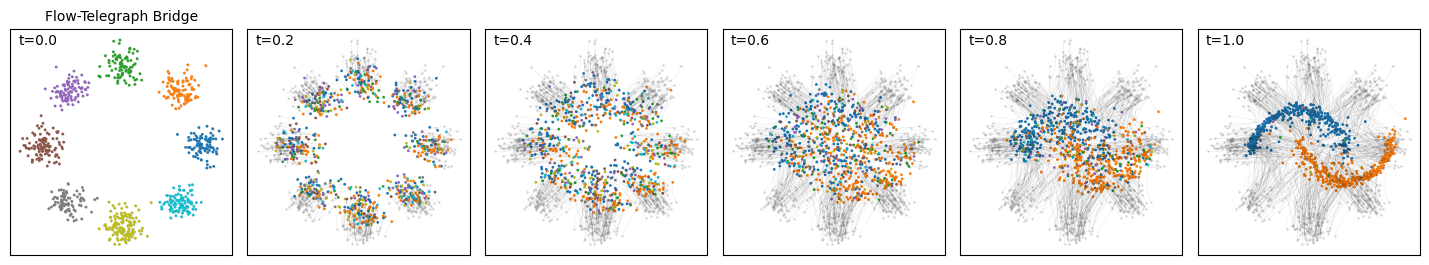

In [ ]:
from utils import plot_trajectories

plot_trajectories(
    pipeline.paths,
    pipeline.jumps,
    title="Flow-Telegraph Bridge",
    N=800,
    show_paths=True,
)

In [5]:
from utils import animate_trajectories

animate_trajectories(
    pipeline.paths,
    pipeline.jumps,
    title="Flow-Telegraph Bridge",
    N=100,
    cmap="tab10",
    show_paths=True,
    filename="ode_trajectories.gif",
    fps=10,
)

/home/df630/CMB/experiments/gaussians/utils.py:55: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  scatter_current = ax.scatter([], [], s=2, cmap=cmap, norm=norm)


Animation saved as ode_trajectories.gif


/home/df630/CMB/experiments/gaussians/utils.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax[j].scatter(paths[0, :N, 0], paths[0, :N, 1], s=1, color='gray', alpha=0.2, vmin=vmin, vmax=vmax)


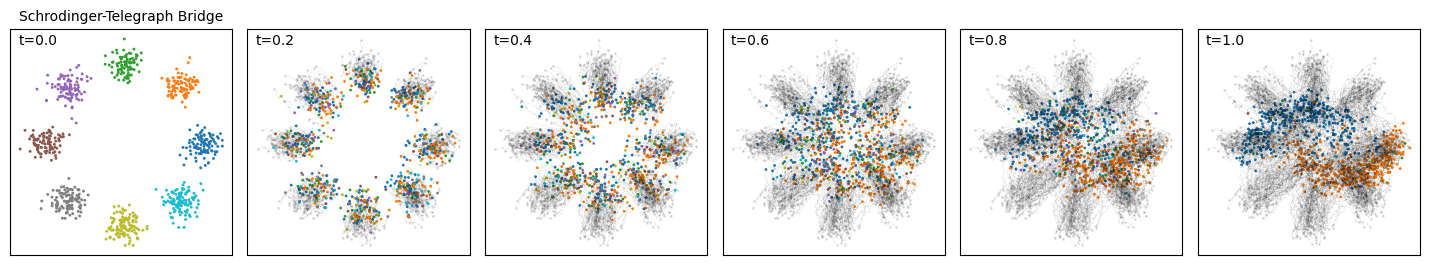

In [9]:
from utils import plot_trajectories

plot_trajectories(
    pipeline.paths,
    pipeline.jumps,
    title="Schrodinger-Telegraph Bridge",
    N=800,
    show_paths=True,
)

In [10]:
from utils import animate_trajectories

animate_trajectories(
    pipeline.paths,
    pipeline.jumps,
    title="Schrodinger-Telegraph Bridge",
    N=100,
    cmap="tab10",
    show_paths=True,
    filename="sde_trajectories.gif",
    fps=10,
)

/home/df630/CMB/experiments/gaussians/utils.py:55: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  scatter_current = ax.scatter([], [], s=2, cmap=cmap, norm=norm)


Animation saved as sde_trajectories.gif


### CMB: 
- $q(x_0, x_1)=q_0(x_0)\cdot q_1(x_1)$
- $q(k_0, k_1)=q_0(k_0)\cdot q_1(k_1)$
- $\lambda=3.0$
- $\gamma=0.125$ 
- $\sigma_{CFM}=0.1$


/tmp/ipykernel_1491123/989848761.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax[j].scatter(paths[0, :N, 0], paths[0, :N, 1], s=1, color='gray', alpha=0.2, vmin=vmin, vmax=vmax)


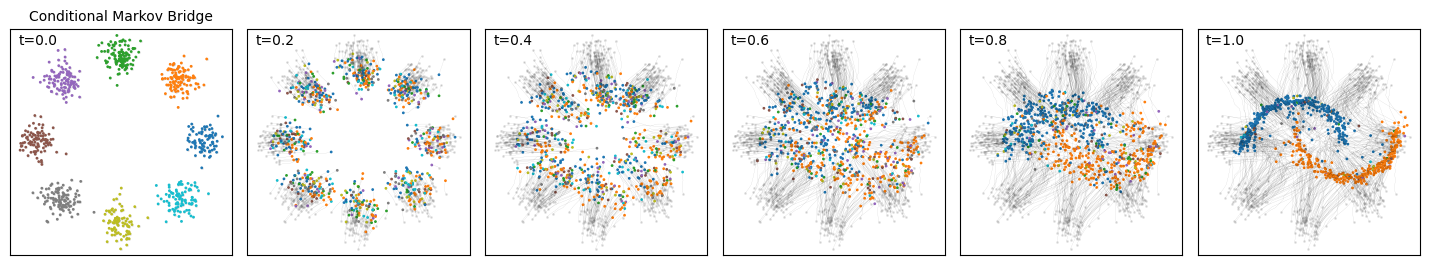

In [35]:
from utils import plot_trajectories

plot_trajectories(
    pipeline.paths,
    pipeline.jumps,
    title="Conditional Markov Bridge",
    N=800,
    show_paths=True,
)

- $q(x_0, x_1)=q_0(x_0)\cdot q_1(x_1)$
- $q(k_0, k_1)=q_0(k_0)\cdot q_1(k_1)$
- $\lambda=1.0$
- $\gamma=10^{-2}$ 
- $\sigma_{CFM}=10^{-5}$


/home/df630/CMB/experiments/gaussians/utils.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax[j].scatter(paths[0, :N, 0], paths[0, :N, 1], s=1, color='gray', alpha=0.2, vmin=vmin, vmax=vmax)


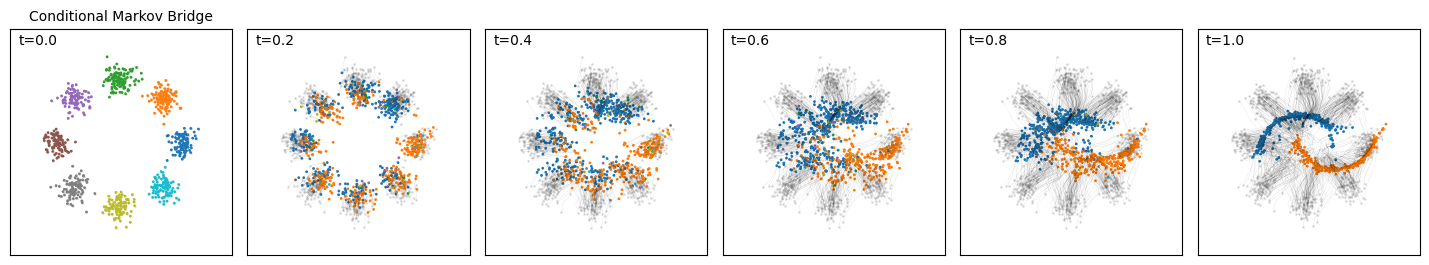

In [4]:
from utils import plot_trajectories

plot_trajectories(
    pipeline.paths,
    pipeline.jumps,
    title="Conditional Markov Bridge",
    N=800,
    show_paths=True,
)

- $q(x_0, x_1)=q_0(x_0)\cdot q_1(x_1)$
- $q(k_0, k_1)=q_0(k_0)\cdot q_1(k_1)$
- $\lambda=3.0$
- $\gamma=10^{-3}$ 
- $\sigma_{CFM}=10^{-5}$


/home/df630/CMB/experiments/gaussians/utils.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax[j].scatter(paths[0, :N, 0], paths[0, :N, 1], s=1, color='gray', alpha=0.2, vmin=vmin, vmax=vmax)


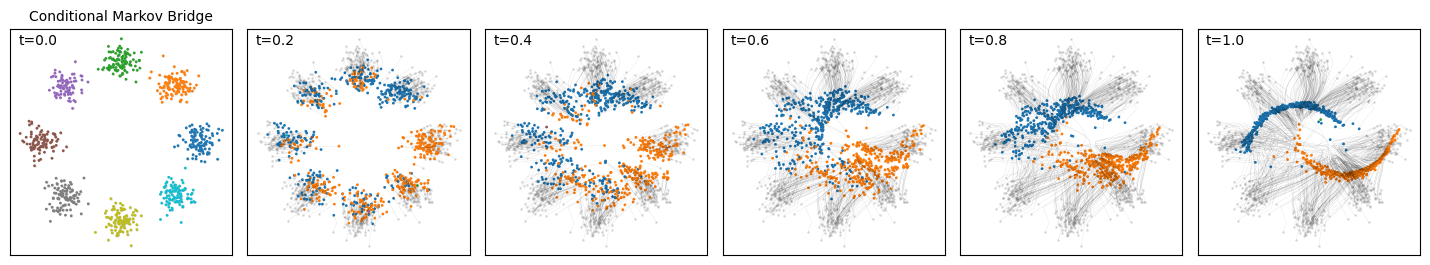

In [4]:
from utils import plot_trajectories

plot_trajectories(
    pipeline.paths,
    pipeline.jumps,
    title="Conditional Markov Bridge",
    N=800,
    show_paths=True,
)

### Batch OT-CMB:

- $q(x_0, x_1)=\pi_{\rm OT}(x_0 ,x_1)$
- $q(k_0, k_1)=q_0(k_0)\cdot q_1(k_1)$
- $\gamma=0.125$ 
- $\sigma_{CFM}=0.1$
- $\lambda=3.0$

/tmp/ipykernel_1520770/989848761.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax[j].scatter(paths[0, :N, 0], paths[0, :N, 1], s=1, color='gray', alpha=0.2, vmin=vmin, vmax=vmax)


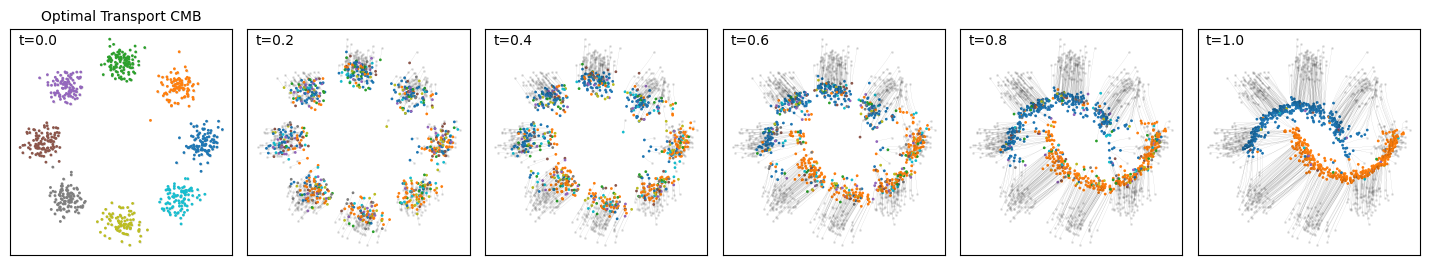

In [6]:
from utils import plot_trajectories

plot_trajectories(
    pipeline.paths,
    pipeline.jumps,
    title="Optimal Transport CMB",
    N=800,
    show_paths=True,
)

/home/df630/CMB/experiments/gaussians/utils.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax[j].scatter(paths[0, :N, 0], paths[0, :N, 1], s=1, color='gray', alpha=0.2, vmin=vmin, vmax=vmax)


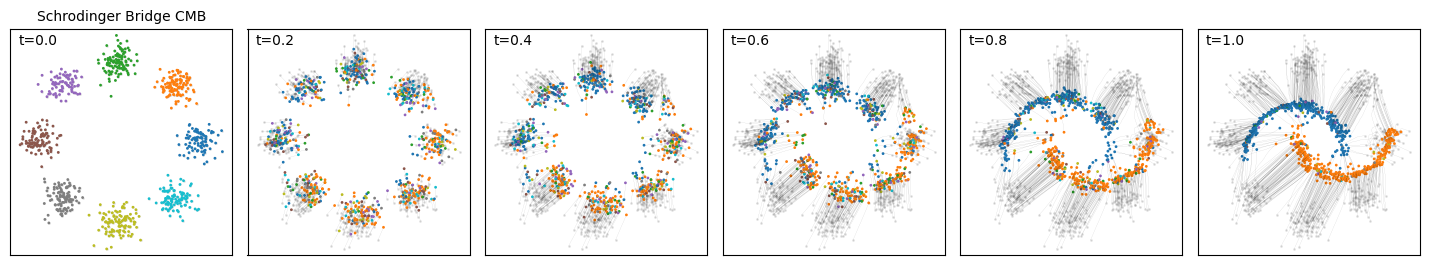

In [4]:
from utils import plot_trajectories

plot_trajectories(
    pipeline.paths,
    pipeline.jumps,
    title="Schrodinger Bridge CMB",
    N=800,
    show_paths=True,
)

In [5]:
from utils import animate_trajectories

animate_trajectories(
    pipeline.paths,
    pipeline.jumps,
    N=200,
    cmap="tab10",
    show_paths=True,
    filename="trajectories.gif",
    fps=10,
)


/home/df630/CMB/experiments/gaussians/utils.py:53: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  scatter_current = ax.scatter([], [], s=2, cmap=cmap, norm=norm)


Animation saved as trajectories.gif
